In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
parent_path = str(Path().joinpath('..').resolve())
sys.path.append(parent_path)

In [3]:
from triple_agent.parsing.replay.get_parsed_replays import get_parsed_replays
from triple_agent.reports.generation.plot_specs import AxisProperties, DataQueryProperties
from triple_agent.constants.events import select_scl5_regular_season
from triple_agent.reports.generation.generic_query import query
from triple_agent.classes.game import Game
from triple_agent.classes.timeline import TimelineCategory
from triple_agent.classes.missions import Missions

In [4]:
scl5_replays = get_parsed_replays(select_scl5_regular_season)

There are many existing reports available (all are shown off in the [examples](../tree/master/examples) folder).  This page will run through the steps of creating a custom report.

## Example 1. Flirt Attempts in First 15 Seconds
For this example, let's create a pie graph for games where the first flirt is _attempted_ (this is an important distinction) within the first 15 seconds of the game.  For most queries, there is a function called [`query`](../tree/master/triple_agent/reports/generic_query.py) which takes a whole lot of arguments, but we'll only be focusing on a few.

To start, let's write the `query_function`.  In general, this function is used to collect the data from the games.  This function takes in the list of games and an input `Counter` class, and populates it with data about those games.  In this case, the counter will have only two keys: `True` and `False`.

This function iterates over all games, and will either increment the counter for `True` if a flirt attempt is seen, or the timeline will move past 15 seconds, so we can increment the `False` condition and move to the next game.

In [5]:
def _flirt_in_15_seconds(games, data_dictionary):
    for game in games:
        for timeline_event in game.timeline:
            if (
                timeline_event.category & TimelineCategory.ActionTest
                and timeline_event.mission & Missions.Seduce
            ):
                data_dictionary[True] += 1
                break
                
            if timeline_event.elapsed_time > 15:
                data_dictionary[False] += 1
                break

To actually perform the collection and plotting, we'll use `query`.

```python
def query(games, data_query, axis_properties):
```

`games`: This is a list of all the games to be included in this report.

`data_query`: This is a `DataQueryProperties` object that determines how the data is collected, sorted and limited.  This include the `query_function` that collects the data from the timeline.

`axis_properties`: This is an `AxisProperties` object that determines how the data is displayed, including which type of graph, labels, title and colors.

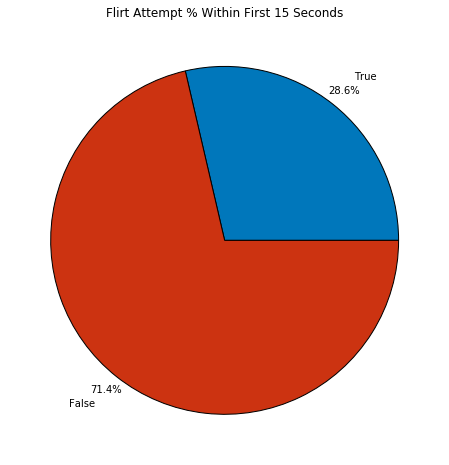

In [6]:
data_properties = query(
    scl5_replays,
    DataQueryProperties(query_function=_flirt_in_15_seconds),
    AxisProperties(
        title='Flirt Attempt % Within First 15 Seconds',
        savefig='example_pictures/example_flirt_15.png')
)

## Example 2. First Completed Mission
This example will be very similar, but we'll be using more classifiers in the counter of our `query_function`, which will add more slices to our pie chart.

In this function, we want to make sure a few things are done.  We need to account for the case where no mission was completed during the game, so we first set `first_mission` to None, and then overwrite it later if a mission was completed.

Also, this will be different because we are using the missions themselves as the keys in our counter.  This means they will also be the legends for any resulting plots.

In [7]:
def _first_mission_completed(games, data_dictionary):
    for game in games:
        first_mission = Missions.NoMission
        for timeline_event in game.timeline:
            if timeline_event.category & TimelineCategory.MissionComplete:
                first_mission = timeline_event.mission
                break

        data_dictionary[first_mission] += 1

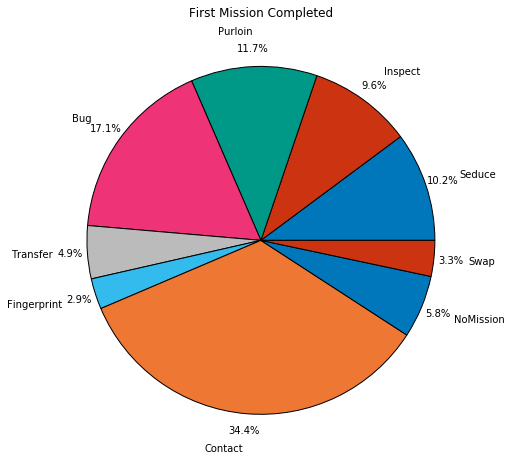

In [8]:
data_properties = query(
    scl5_replays,
    DataQueryProperties(query_function=_first_mission_completed),
    AxisProperties(
        title='First Mission Completed',
        savefig='example_pictures/example_first_mission.png')
)

However, this data may look nicer in a bar or line plot.  We can do that by using `force_bar=True` or `force_line=True`.

Which results in this new plot, based on the same data:

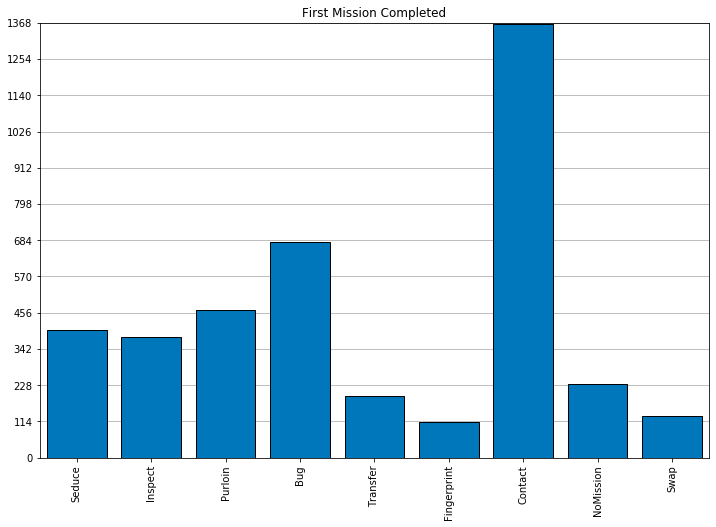

In [9]:
data_properties = query(
    scl5_replays,
    DataQueryProperties(query_function=_first_mission_completed),
    AxisProperties(title='First Mission Completed', force_bar=True)
)

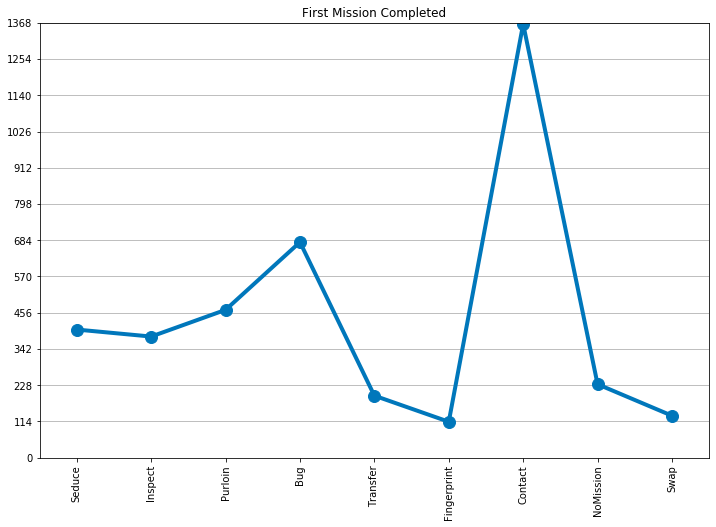

In [10]:
data_properties = query(
    scl5_replays,
    DataQueryProperties(query_function=_first_mission_completed),
    AxisProperties(title='First Mission Completed', force_line=True)
)